 ***All code is adapted from Patrick Laub's ACTL3143 Slides
https://pat-laub.github.io/DeepLearningMaterials/2023/Lecture-4-Computer-Vision/computer-vision.html***



# Q1: Convolutional Neural Network

## Importing Packages

In [33]:
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

## Downloading Dataset from GitHub

In [34]:
from pathlib import Path
if not Path("hurricane").exists():
  print("Downloading dataset...")
  !wget https://pat-laub.github.io/DeepLearningMaterials/2023/Lecture-4-Computer-Vision/hurricane.zip
  !unzip hurricane.zip
else:
  print("Already downloaded.")

Already downloaded.


## Installing File Directory Packages

In [35]:
!pip install directory_tree
from directory_tree import display_tree

!pip install split-folders
import splitfolders
splitfolders.ratio("hurricane", output="hurricane-split",
    seed=1337, ratio=(5/7, 1/7, 1/7))

display_tree("hurricane-split", max_depth=1)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 21492 files [00:03, 5756.72 files/s]

hurricane-split/
├── test/
├── train/
└── val/


## Building and Splitting Dataset into Train, Test and Val

In [36]:
from tensorflow.keras.utils import\
  image_dataset_from_directory

data_dir = "hurricane-split"
batch_size = 32
img_height = 128
img_width = 128
img_size = (img_height, img_width)

val_ds = image_dataset_from_directory(
    data_dir + "/val",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    color_mode='grayscale')

train_ds = image_dataset_from_directory(
    data_dir + "/train",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    color_mode='grayscale')

test_ds = image_dataset_from_directory(
    data_dir + "/test",
    image_size=img_size,
    batch_size=batch_size,
    shuffle=False,
    color_mode='grayscale')

Found 3069 files belonging to 2 classes.
Found 15350 files belonging to 2 classes.
Found 3073 files belonging to 2 classes.


In [37]:
X_train = np.concatenate(list(train_ds.map(lambda x, y: x)))
y_train = np.concatenate(list(train_ds.map(lambda x, y: y)))

X_val = np.concatenate(list(val_ds.map(lambda x, y: x)))
y_val = np.concatenate(list(val_ds.map(lambda x, y: y)))

X_test = np.concatenate(list(test_ds.map(lambda x, y: x)))
y_test = np.concatenate(list(test_ds.map(lambda x, y: y)))

## Building the Model

In [38]:
from tensorflow.keras.layers \
  import Rescaling, Conv2D, MaxPooling2D, Flatten

numClasses = np.unique(y_train).shape[0]
random.seed(123)

model = Sequential([
  Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  Conv2D(16, 3, padding="same", activation="relu", name="conv1"),
  MaxPooling2D(name="pool1"),
  Conv2D(32, 3, padding="same", activation="relu", name="conv2"),
  MaxPooling2D(name="pool2"),
  Conv2D(64, 3, padding="same", activation="relu", name="conv3"),
  MaxPooling2D(name="pool3"),
  Flatten(), Dense(128, activation="relu"), Dense(numClasses)
])

## Training the Model

In [39]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
topk = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)
model.compile(optimizer='adam', loss=loss, metrics=['accuracy', topk])

epochs = 100
es = EarlyStopping(patience=15, restore_best_weights=True,
    monitor="val_accuracy", verbose=2)

hist = model.fit(train_ds.shuffle(1000), validation_data=val_ds,
  epochs=epochs, callbacks=[es], verbose=0)

Restoring model weights from the end of the best epoch: 1.
Epoch 16: early stopping


## Plotting Loss Functions

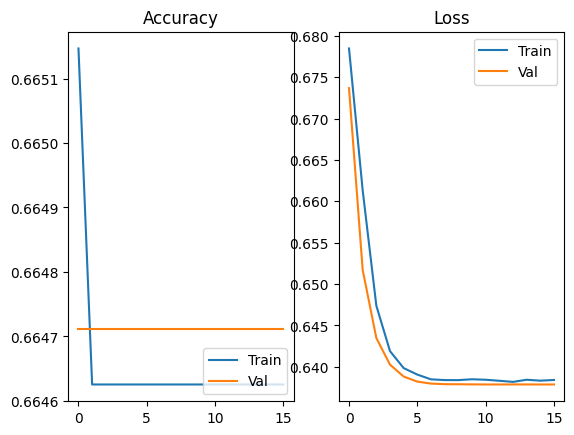

[0.6736891865730286, 0.6646254062652588, 1.0]
[0.6736791133880615, 0.6647116541862488, 1.0]
[0.6737052798271179, 0.6644972562789917, 1.0]


In [40]:
def plot_history(hist):
    epochs = range(len(hist.history["loss"]))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, hist.history["accuracy"], label="Train")
    plt.plot(epochs, hist.history["val_accuracy"], label="Val")
    plt.legend(loc="lower right")
    plt.title("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot(epochs, hist.history["loss"], label="Train")
    plt.plot(epochs, hist.history["val_loss"], label="Val")
    plt.legend(loc="upper right")
    plt.title("Loss")
    plt.show()

plot_history(hist)

print(model.evaluate(train_ds, verbose=0))
print(model.evaluate(val_ds, verbose=0))
print(model.evaluate(test_ds, verbose=0))

## Sampling Some Predictions

[[ 0.06562985 -0.06562985]]
damage


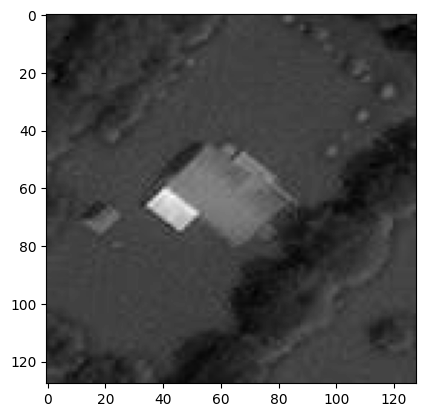

In [56]:
print(model.predict(X_test[[25]], verbose=0))
print(test_ds.class_names[model.predict(X_test[[25]], verbose=0).argmax()])
plt.imshow(X_test[25], cmap="gray");

## Hyperparameter Tuning

In [53]:
!pip install keras-tuner

import keras_tuner as kt

def build_model(hp):
    model = Sequential()
    model.add(
        Dense(
            hp.Choice("neurons", [4, 8, 16, 32, 64, 128, 256]),
            activation=hp.Choice("activation",
                ["relu", "leaky_relu", "tanh"]),
        )
    )

    model.add(Dense(1, activation="exponential"))

    learning_rate = hp.Float("lr",
        min_value=1e-4, max_value=1e-2, sampling="log")
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss="poisson")

    return model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [55]:
tuner = kt.BayesianOptimization(
  build_model,
  objective="val_loss",
  directory="bayesian-search",
  max_trials=10)

es = EarlyStopping(patience=3,
  restore_best_weights=True)

tuner.search(X_train, y_train,
  epochs=100, callbacks = [es],
  validation_data=(X_val, y_val))

best_model = tuner.get_best_models()[0]

tuner.results_summary(1)

Trial 10 Complete [00h 03m 23s]
val_loss: 0.7020725607872009

Best val_loss So Far: 0.7017172574996948
Total elapsed time: 00h 08m 20s
Results summary
Results in bayesian-search/untitled_project
Showing 1 best trials
Objective(name="val_loss", direction="min")

Trial 04 summary
Hyperparameters:
neurons: 64
activation: tanh
lr: 0.0010062870411529313
Score: 0.7017172574996948
